# **Stage 1:** Producing simulation data

- Generating 30,000 unique visitors
- Each user generates 1-3 sessions (weighted towards 1 session to resemble real behaviour)
- Each session produces a variable number of funnel events (dependant on drop off)
- Data simulates funnel with abandonment, return visit, and browsing events
- Integrates bot traffic
- Outputs to a CSV for transformation

In [10]:
import numpy as np
import pandas as pd
import random
from datetime import datetime, timedelta
import uuid

# Setting random seed for reproducibility
np.random.seed(42)
random.seed(42)

# Simulation parameters
NUM_USERS = 30000
START_DATE = datetime(2025, 1, 1)
END_DATE = datetime(2025, 1, 7)
EVENT_TYPES = [
    "view_homepage", "view_category", "view_product",
    "add_to_cart", "checkout", "purchase"
]
DEVICES = ["desktop", "mobile"]
REFERRERS = ["organic", "paid_ads", "email", "social", "direct"]
CATEGORIES = range(1, 11)
PRODUCTS = range(100, 200)

# Funnel progression probabilities
FUNNEL_PROBS = {
    "view_homepage": 1.0,
    "view_category": 0.8,
    "view_product": 0.6,
    "add_to_cart": 0.4,
    "checkout": 0.3,
    "purchase": 0.25
}

# Anomaly config
ANOMALY_DAY = datetime(2025, 6, 4)  # Introduce drop-off anomaly on this day
ANOMALY_DROP_STAGE = "checkout"
ANOMALY_DROP_MULTIPLIER = 0.5  # 50% higher drop-off rate

# Bot traffic config
BOT_PERCENTAGE = 0.02  # 2% of users
BOT_EVENT_INTERVAL_MEAN = 1  # unrealistically fast (seconds)

# Helper functions
def random_timestamp(start_date, end_date):
    delta = end_date - start_date
    random_second = random.randint(0, int(delta.total_seconds()))
    return start_date + timedelta(seconds=random_second)

def simulate_session(user_id, is_bot):
    session_id = str(uuid.uuid4())
    timestamp = random_timestamp(START_DATE, END_DATE)
    device = random.choice(DEVICES)
    referrer = random.choice(REFERRERS)

    events = []
    proceed = True

    for event in EVENT_TYPES:
        if not proceed:
            break

        # Simulate drop-off probability
        prob = FUNNEL_PROBS[event]

        # Inject anomaly if applicable
        if event == ANOMALY_DROP_STAGE and timestamp.date() == ANOMALY_DAY.date():
            prob *= ANOMALY_DROP_MULTIPLIER

        # Decide whether to log event
        if np.random.rand() <= prob:
            event_time = timestamp
            if is_bot:
                # Unrealistically fast event timing for bots
                timestamp += timedelta(seconds=np.random.exponential(BOT_EVENT_INTERVAL_MEAN))
            else:
                # Normal browsing pace
                timestamp += timedelta(seconds=random.randint(10, 300))

            events.append({
                "user_id": user_id,
                "session_id": session_id,
                "timestamp": event_time,
                "event_type": event,
                "product_id": random.choice(PRODUCTS),
                "category_id": random.choice(CATEGORIES),
                "device_type": device,
                "referrer": referrer
            })

            # Simulate abandonment at this stage
            if np.random.rand() > prob:
                proceed = False
        else:
            proceed = False

    return events

# Main simulation loop
all_events = []

for user_id in range(1, NUM_USERS + 1):
    is_bot = np.random.rand() < BOT_PERCENTAGE
    num_sessions = np.random.choice([1, 2, 3], p=[0.7, 0.2, 0.1])  # Some return visits

    for _ in range(num_sessions):
        session_events = simulate_session(user_id, is_bot)
        all_events.extend(session_events)

# Convert to DataFrame
df = pd.DataFrame(all_events)

# Shuffle data for realism
df = df.sample(frac=1).reset_index(drop=True)

# Output to CSV
df.to_csv("simulated_funnel_events.csv", index=False)

print(f"Simulation complete — {len(df)} events generated across {NUM_USERS} users.")


Simulation complete — 96080 events generated across 30000 users.


# **Stage 2:** ETL Pipeline

- Ingesting the raw CSV
- Cleaning data
- Calculating session durations and time spent per funnel stage
- Combining funnel metrics ready for Streamlit dashboard
- Bot detection features

In [17]:
import pandas as pd
import numpy as np

# --- Configuration ---
RAW_DATA_PATH = "simulated_funnel_events.csv"
BOT_EVENT_INTERVAL_THRESHOLD = 2  # seconds, unrealistic speed => flag as bot
ANOMALY_DROP_THRESHOLD = 0.3  # if drop-off between steps > threshold → flag anomaly

# --- ETL Pipeline Steps ---

# Extract
def extract_data(path):
    df = pd.read_csv(path, parse_dates=["timestamp"])
    return df

# Clean & Transform
def clean_data(df):
    # Remove missing / invalid entries
    df = df.dropna(subset=["user_id", "session_id", "timestamp", "event_type"])
    
    # Filter invalid event types (just in case)
    valid_events = [
        "view_homepage", "view_category", "view_product",
        "add_to_cart", "checkout", "purchase"
    ]
    df = df[df["event_type"].isin(valid_events)]
    
    return df

# Bot detection based on event timing per session
def detect_bots(df):
    df_sorted = df.sort_values(["session_id", "timestamp"])
    df_sorted["time_diff"] = df_sorted.groupby("session_id")["timestamp"].diff().dt.total_seconds()
    
    bot_sessions = df_sorted.groupby("session_id")["time_diff"].mean()
    bot_sessions = bot_sessions[bot_sessions <= BOT_EVENT_INTERVAL_THRESHOLD].index.tolist()
    
    print(f"Detected {len(bot_sessions)} bot sessions")
    
    return bot_sessions

# Calculating session duration
def compute_session_duration(df):
    session_duration = df.groupby("session_id")["timestamp"].agg(["min", "max"])
    session_duration["duration_seconds"] = (session_duration["max"] - session_duration["min"]).dt.total_seconds()
    return session_duration

# Calculating funnel metrics
def compute_funnel_metrics(df, exclude_sessions=None):
    if exclude_sessions:
        df = df[~df["session_id"].isin(exclude_sessions)]
    
    # Users per funnel step
    users_per_step = df.groupby("event_type")["user_id"].nunique().reindex([
        "view_homepage", "view_category", "view_product", "add_to_cart", "checkout", "purchase"
    ]).fillna(0).astype(int)

    # Conversion rates
    conversion_rates = users_per_step / users_per_step.shift(1)
    conversion_rates.iloc[0] = np.nan  # First step has no previous step
    
    # Drop-off rates
    drop_off_rates = 1 - conversion_rates
    
    # Detect anomaly
    anomaly_flags = drop_off_rates > ANOMALY_DROP_THRESHOLD
    
    funnel_df = pd.DataFrame({
        "users": users_per_step,
        "conversion_rate": conversion_rates,
        "drop_off_rate": drop_off_rates,
        "anomaly": anomaly_flags
    })
    
    return funnel_df

# Main ETL Run
if __name__ == "__main__":
    print("Running ETL pipeline...")
    
    # Extract
    df_raw = extract_data(RAW_DATA_PATH)
    print(f"Extracted {len(df_raw)} events")
    
    # Clean
    df_clean = clean_data(df_raw)
    print(f"Cleaned data: {len(df_clean)} events remaining")
    
    # Detect bots
    bot_sessions = detect_bots(df_clean)
    
    # Compute session duration
    session_duration_df = compute_session_duration(df_clean)
    
    # Compute funnel metrics (excluding bots)
    funnel_metrics_df = compute_funnel_metrics(df_clean, exclude_sessions=bot_sessions)
    
    # Save intermediate results (optional)
    funnel_metrics_df.to_csv("funnel_metrics.csv")
    session_duration_df.to_csv("session_durations.csv")
    
    print("ETL complete. Funnel metrics and session durations saved.")


Running ETL pipeline...
Extracted 96080 events
Cleaned data: 96080 events remaining
Detected 582 bot sessions
ETL complete. Funnel metrics and session durations saved.


# **Stage 3:** Deploying to Streamlit Dashboard

**Note:** Jupyter Notebooks doesn't support Streamlit dashboard so this needs to be ran from the terminal

- Outputs interactive funnel chart
- Filters: device, referrer, date range
- Anomaly warnings
- Conceptual 'live' refresh
- Loads ETL outputs

In [ ]:
# streamlit_funnel_dashboard.py

import streamlit as st
import pandas as pd
import plotly.graph_objects as go

# Config
RAW_DATA_PATH = "simulated_funnel_events.csv"
FUNNEL_METRICS_PATH = "funnel_metrics.csv"

# Load data
@st.cache_data
def load_data():
    df_events = pd.read_csv(RAW_DATA_PATH, parse_dates=["timestamp"])
    df_funnel = pd.read_csv(FUNNEL_METRICS_PATH, index_col=0)
    return df_events, df_funnel

# Filter data
def filter_data(df, device_filter, referrer_filter, date_range):
    df_filtered = df.copy()
    
    if device_filter != "All":
        df_filtered = df_filtered[df_filtered["device_type"] == device_filter]
    
    if referrer_filter != "All":
        df_filtered = df_filtered[df_filtered["referrer"] == referrer_filter]
    
    df_filtered = df_filtered[
        (df_filtered["timestamp"].dt.date >= date_range[0]) &
        (df_filtered["timestamp"].dt.date <= date_range[1])
    ]
    
    return df_filtered

# Plot funnel using Plotly
def plot_funnel(funnel_df):
    fig = go.Figure()

    fig.add_trace(go.Funnel(
        y=funnel_df.index.tolist(),
        x=funnel_df["users"].tolist(),
        textinfo="value+percent previous+percent initial",
        marker={"color": [
            "#FDE8D0", "#FDD1A0", "#FDB870", "#FD9F50", "#FD8040", "#FD6030"
        ]}
    ))

    fig.update_layout(
        title="Funnel Metrics",
        margin=dict(l=50, r=50, t=80, b=50),
        plot_bgcolor='white'
    )

    st.plotly_chart(fig, use_container_width=True)

# --- Streamlit app ---
st.set_page_config(page_title="Live Funnel Dashboard", layout="centered")

st.title("Live Funnel Analysis Dashboard")
st.caption("Conceptual real-time funnel visualisation for e-commerce conversion optimisation")

# Load data
df_events, df_funnel = load_data()

# Sidebar filters
st.sidebar.header("Filters")

device_filter = st.sidebar.selectbox(
    "Device Type", ["All"] + sorted(df_events["device_type"].unique().tolist())
)

referrer_filter = st.sidebar.selectbox(
    "Referrer", ["All"] + sorted(df_events["referrer"].unique().tolist())
)

date_range = st.sidebar.date_input(
    "Date Range",
    value=[df_events["timestamp"].dt.date.min(), df_events["timestamp"].dt.date.max()],
    min_value=df_events["timestamp"].dt.date.min(),
    max_value=df_events["timestamp"].dt.date.max()
)

# Apply filters
df_filtered = filter_data(df_events, device_filter, referrer_filter, date_range)

# Recompute funnel metrics from filtered data
users_per_step = df_filtered.groupby("event_type")["user_id"].nunique().reindex([
    "view_homepage", "view_category", "view_product",
    "add_to_cart", "checkout", "purchase"
]).fillna(0).astype(int)

conversion_rates = users_per_step / users_per_step.shift(1)
conversion_rates.iloc[0] = None
drop_off_rates = 1 - conversion_rates
anomaly_flags = drop_off_rates > 0.3

funnel_df_filtered = pd.DataFrame({
    "users": users_per_step,
    "conversion_rate": conversion_rates,
    "drop_off_rate": drop_off_rates,
    "anomaly": anomaly_flags
})

# Show anomaly warnings
if funnel_df_filtered["anomaly"].any():
    st.error("⚠️ Anomaly detected! High drop-off rate at one or more stages.")
else:
    st.success("✅ No anomalies detected.")

# Show funnel chart (Plotly)
plot_funnel(funnel_df_filtered)

# Optional — show raw data
with st.expander("Show Raw Events Data"):
    st.dataframe(df_filtered)

# Optional — rerun ETL button (conceptual)
if st.button("🔄 Rerun ETL & Refresh Dashboard"):
    st.warning("Manual rerun concept — please execute the ETL script and refresh Streamlit app.")


## Expected Output:

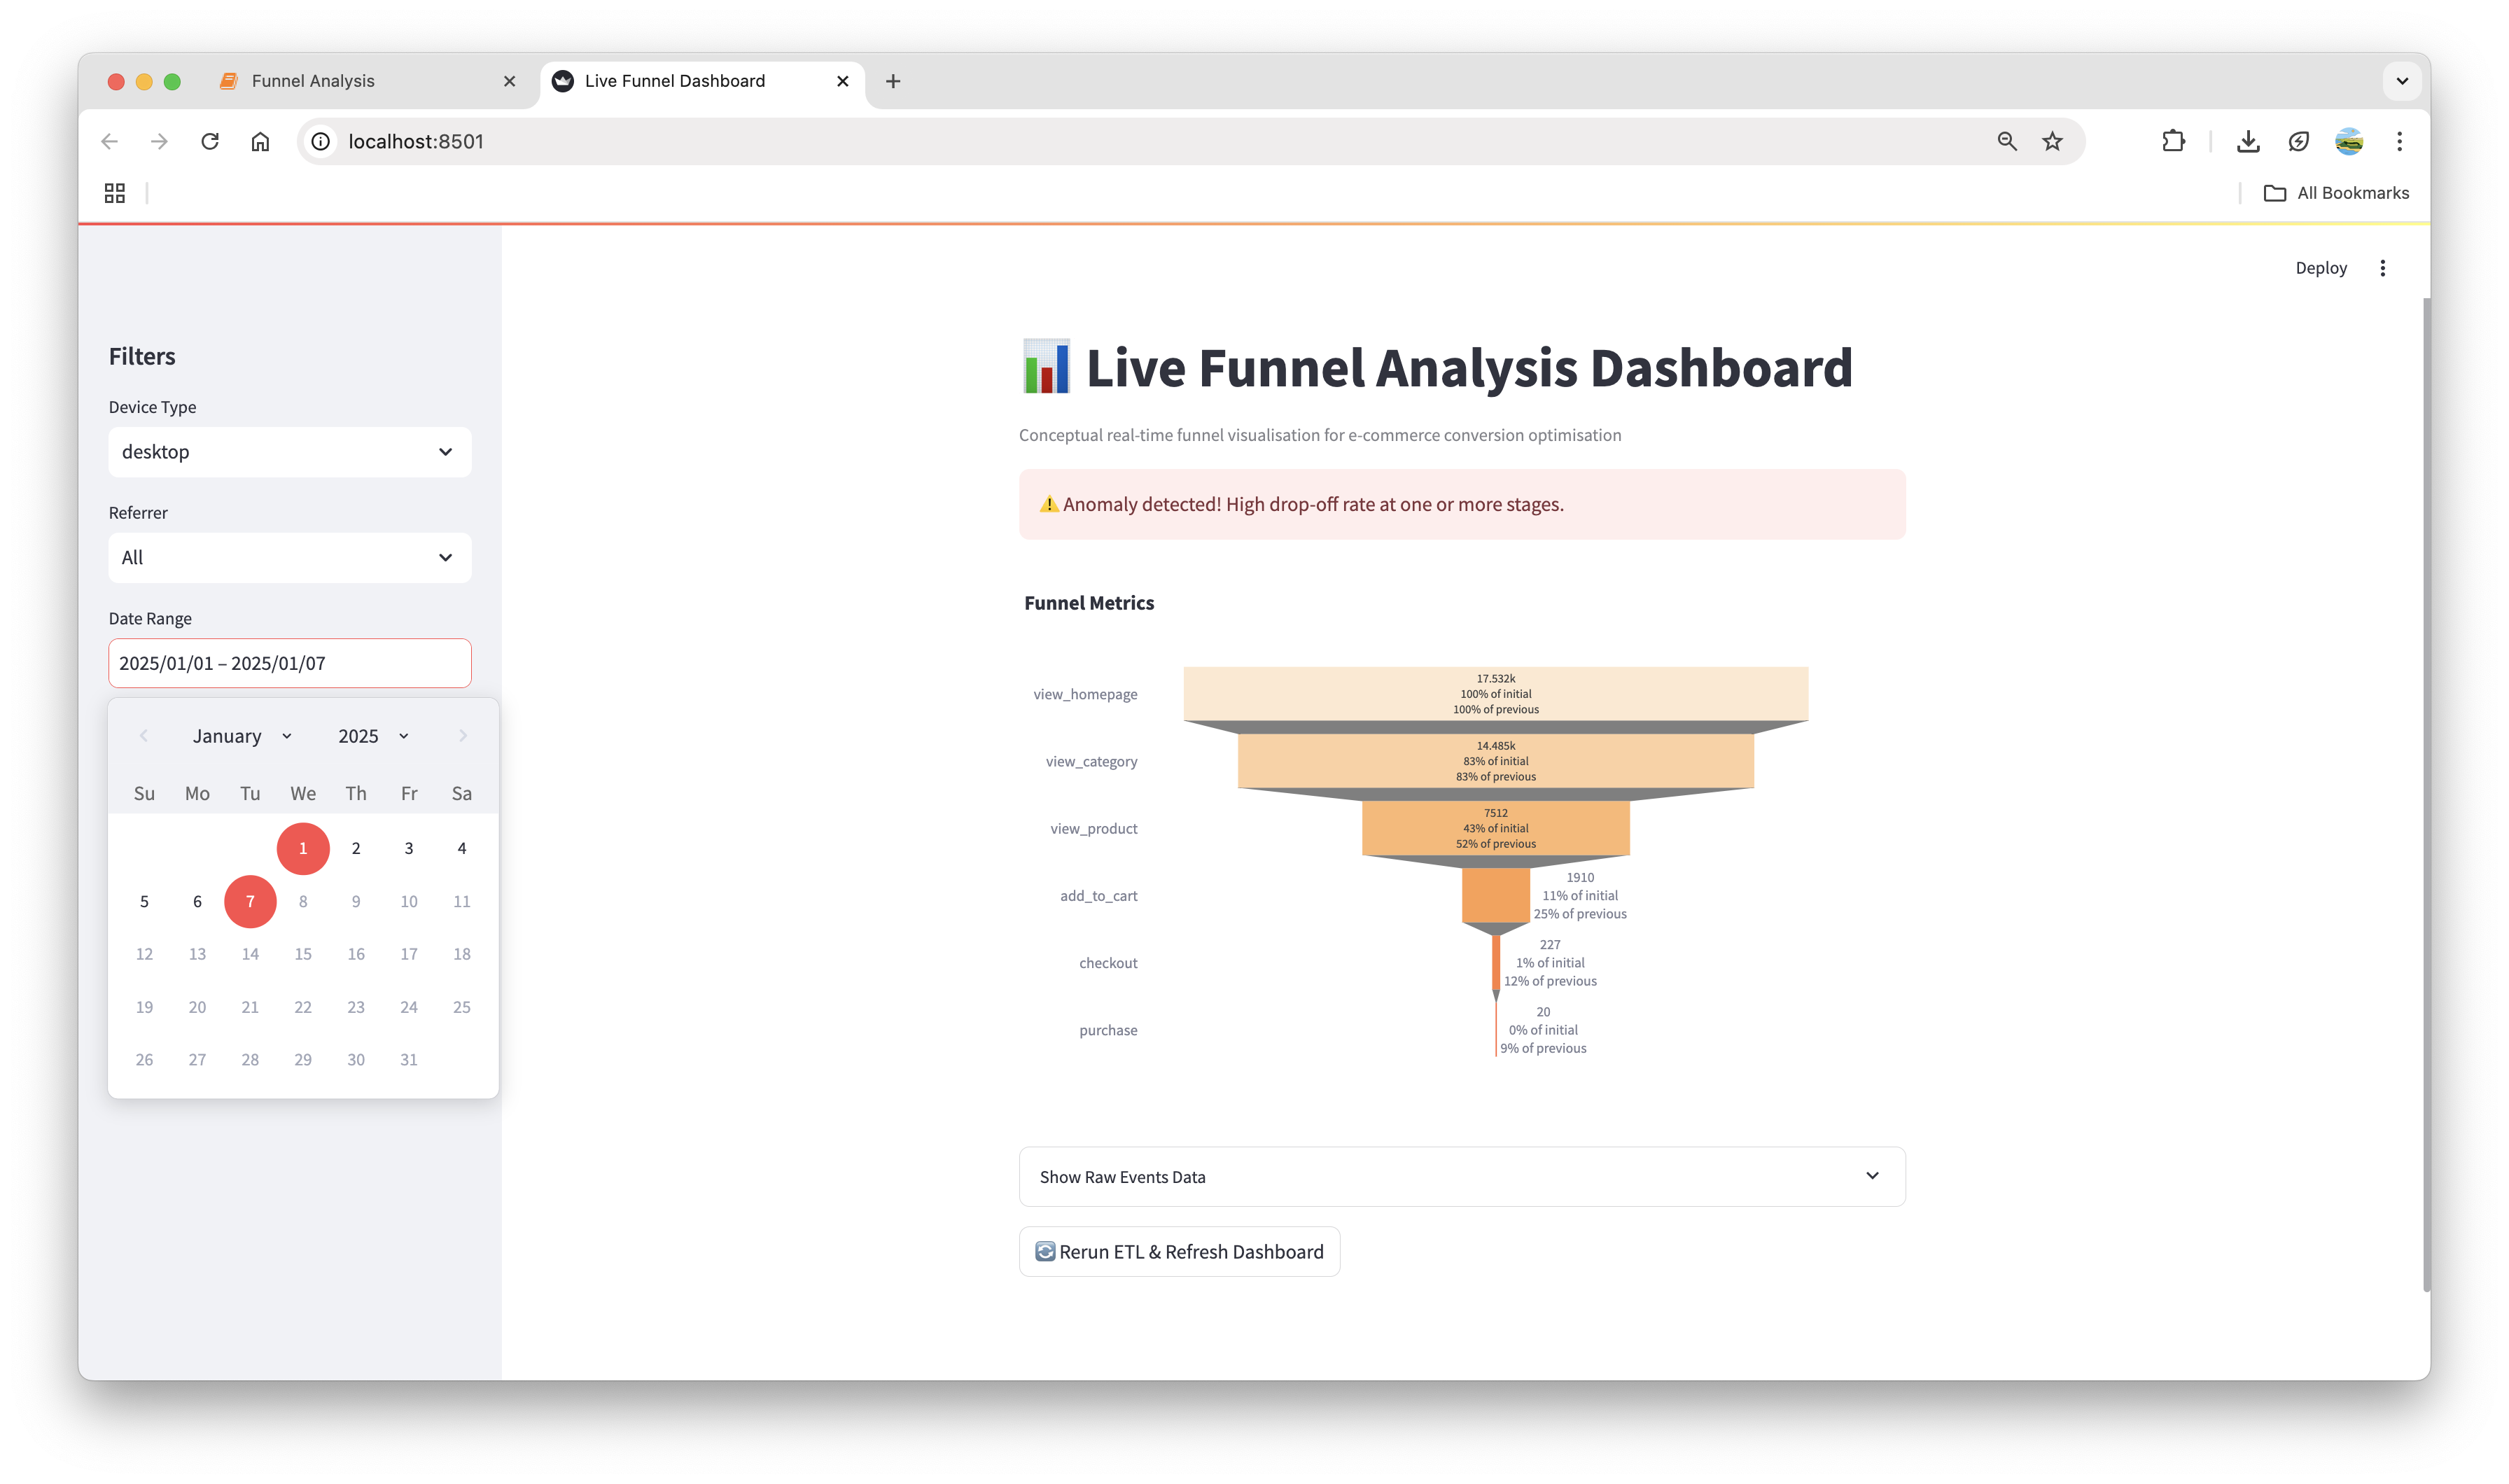



# **Analysis**

## Overview

- Overall conversion rate from homepage -> purchase: ~**0.13%**
    - Quite a low outcome but this was intended through the high drop-off rate probabilities in the data
- The largest drop-offs occured between:
    - view_product -> add_to_card (73.2% drop)
    - checkout -> purchase (91.4% drop)

## Per Stage Conversion Rates

| Funnel Stage    | Conversion Rate to Next Step | Drop off Rate    |
| -------- | ------- | -------- |
| View Homepage -> Category | 84.6% | 15.4% |
| View Category -> Product | 55.0% | 45.0% |
| View Product -> Add to Cart | 26.8% | 73.2% |
| Add to Cart -> Checkout | 12.2% | 87.8% |
| Checkout -> Purchase | 8.6% | 91.4% |

## Anomalies

- High drop off rates were detected beyond normal thresholds:
    - Product page -> Add to Cart
    - Checkout -> Purchase
- Likely causes of the 'anomalies':
    - Checkout issues, discounts not applying, UX failures

## Bot Traffic

- Approx 582 sessions (~2%) flagged as potential bots based on event timing
- These sessions were excluded from the funnel to avoid skewing conversion rates
- In production, real-time bot detection through IP checking and navigation speeds should be integrated

## Device Conversion Patterns

- Consistent across Desktop and Mobile (0.11%) for Homepage -> Purchase

## Referrer Conversion Patterns

| Referrer    | Conversion Rate (Homepage -> Purchase) |
| -------- | ------- |
| **Direct**  | **0.15%**    |
| Organic | 0.14%     |
| Email    | 0.09%    |
| Social    | 0.06%    |
| **Paid Ads**    | **0.06%**    |

- Direct and organic traffic demonstrated the strongest conversion rates
- Paid and social traffic converted poorly **suggesting campaign targetting needs to be improved**